# 2. Modelling


## To Do

Models:
- LogReg - GridSearch, Improve Precision ....
- Random Forest - GridSearch, Improve precision
- Random Forest - Get feature importance to see main contributors
- MLPClassifier - more parameters, iterations, F1 scoring ...
- Best metrics, eg precision due the cost of a sales contact .... use f1 instead of accuracy .. but crashes
- Understand Gini index (least is best etc)

And:
- MLP - Use Keras to create an MLP, see week 5 Wine notebook
- Add a loop like week 9 to produce a summary comparison? .. or just do manually in poster
- One best model found then retrain again and get different metrics??
- Repeat with PCA components to improve feature selection
- Repeat with changes in features
- ?? SMOTE



## Imports & Utilities

In [1]:
# General stuff
import os
import time

# Import maths related packages
import pandas as pd
import numpy as np
import math

# Import plotting packages
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# Reset to Default
# plt.style.use('default')


In [2]:
# ML Models & Evaluation

from sklearn import model_selection

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


In [3]:
# Function to Display The Model Fit Results

def print_search_results(search, duration):
    print('------- Search Results --------')
    all_search_results = pd.DataFrame(search.cv_results_)
    print(f"Score: {search.best_score_:.4f}. Mean: {np.mean(all_search_results['mean_test_score']):.4f} and STD {np.std(all_search_results['mean_test_score']):.4f}")
    print(f'Search Took: {duration:.2f} seconds')
    print(f"Best Parameters: {search.best_params_}")
    top_n = 10
    print(f"Top {top_n} out of {len(all_search_results)} combinations:")
    display(all_search_results[['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']].sort_values(by='rank_test_score').head(top_n))

In [4]:
# Function to Present the Evaluation Metrics for a Classification Model

def classification_metrics(for_Model, X_test, y_test, y_pred):
    plt.style.use('default')

    # Calculate Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Print various metrics
    print(f'Accuracy: {metrics.accuracy_score(y_true=y_test, y_pred=y_pred):.4f}')
    print(f'Precision: {metrics.precision_score(y_true=y_test, y_pred=y_pred, pos_label="yes"):.4f}')
    print(f'Recall: {metrics.recall_score(y_true=y_test, y_pred=y_pred, pos_label="yes"):.4f}')
    print(f'F1 Score {metrics.f1_score(y_true=y_test, y_pred=y_pred, pos_label="yes"):.4f}')
    print(f'Specificity: {tn / (tn + fp):.4f}')
    print(f'Hamming Loss {metrics.hamming_loss(y_true=y_test, y_pred=y_pred):.4f}')


    # Plot Confusion Matrix
    class_labels = for_Model.classes_
    fig, ax = plt.subplots(figsize=(12,4))
    ax.set_title('Confusion Matrix')
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(ax=ax)
    plt.show

    y_probabilities = for_Model.predict_proba(X_test)[:, 1]
    roc_auc_score = metrics.roc_auc_score(y_true=y_test, y_score=y_probabilities)
    print(f'ROC-AUC Score {roc_auc_score:.4f}')
    gini_score = 2 * roc_auc_score - 1
    print(f'Gini Index: {gini_score:.4f}')

    # Plot the ROC curve
    fig, ax = plt.subplots(figsize=(6,4))
    ax.set_title('ROC Curve')
    roc_display = RocCurveDisplay.from_estimator(for_Model, X_test, y_test, ax=ax, pos_label="yes")
    plt.show()

    plt.style.use('ggplot')

## Load the Prepared Data

In [5]:
# Load saved dataset
import pickle

with open('xy_data.pickle', 'rb') as file:
    X_train, X_test, y_train, y_test = pickle.load(file)

In [6]:
# Create custom scorers to cater for 'yes/no' vs '0/1' target variable 
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
custom_precision_score = make_scorer(precision_score, pos_label='yes')
custom_recall_score = make_scorer(recall_score, pos_label='yes')
custom_f1_score = make_scorer(f1_score, pos_label='yes')

# scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']


## Logistic Regression

In [7]:
# Logistic Regression

# Establish a pipeline for a randomised search & get the best fitted model
logreg_pipeline = make_pipeline(
    LogisticRegression(random_state=42)
)
grid_params = {
    'logisticregression__penalty': ['l1', 'l2'],                # L1 or L2 regularisation
    'logisticregression__solver': ['saga', 'liblinear'],        # Saga is a variant of Sag. With L1 or l2. Large dataset. liblinear is for small datasets, binary classifications
    'logisticregression__C': [0.01, 0.1, 1, 5],                 # Strength of regularisation, default is 1, smaller is stronger
    'logisticregression__max_iter': [600],                      # Max ??? iterations seems to be sufficient
    'logisticregression__class_weight': ['balanced'],            # Balanced seems to give a better recall & precision
    # 'logisticregression__class_weight': [None, 'balanced']    # Tries to adjust to balance for classes that are imbalanced .... balanced seems best but search doesn't find it!?
}
# scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
# scoring = {
#     'accuracy': 'accuracy',
#     'f1': custom_f1_score
# }


# Run the search
start_time = time.perf_counter()
# rand_search = RandomizedSearchCV(logreg_pipeline, grid_params, scoring=scoring, cv=5, refit='accuracy')
# rand_search = RandomizedSearchCV(logreg_pipeline, grid_params, scoring='accuracy', cv=5)
# rand_search = GridSearchCV(logreg_pipeline, grid_params, scoring='roc_auc', cv=5)
# logreg_search = RandomizedSearchCV(logreg_pipeline, grid_params, scoring='roc_auc', cv=5)
logreg_search = RandomizedSearchCV(logreg_pipeline, grid_params, scoring=custom_f1_score, cv=5)

logreg_search.fit(X_train, y_train)
duration = time.perf_counter() - start_time


/opt/anaconda3/envs/ml_v4_20250323/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_v4_20250323/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_v4_20250323/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_v4_20250323/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_v4_20250323/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/

------- Search Results --------
Score: 0.4302. Mean: 0.4290 and STD 0.0007
Search Took: 45.73 seconds
Best Parameters: {'logisticregression__solver': 'saga', 'logisticregression__penalty': 'l2', 'logisticregression__max_iter': 600, 'logisticregression__class_weight': 'balanced', 'logisticregression__C': 0.01}
Top 10 out of 10 combinations:


,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
2,1,0.430233,1.224164,0.023853,"{'logisticregression__solver': 'saga', 'logist..."
9,2,0.429686,0.050507,0.019717,"{'logisticregression__solver': 'liblinear', 'l..."
7,3,0.429532,1.914391,0.019853,"{'logisticregression__solver': 'saga', 'logist..."
8,4,0.429209,1.288090,0.020086,"{'logisticregression__solver': 'saga', 'logist..."
6,5,0.429156,2.447809,0.019860,"{'logisticregression__solver': 'saga', 'logist..."
1,6,0.428960,1.300422,0.019969,"{'logisticregression__solver': 'saga', 'logist..."
3,7,0.428363,0.115553,0.019847,"{'logisticregression__solver': 'liblinear', 'l..."
5,8,0.428234,0.116532,0.019900,"{'logisticregression__solver': 'liblinear', 'l..."
4,9,0.428181,0.055846,0.019656,"{'logisticregression__solver': 'liblinear', 'l..."
0,10,0.428132,0.116729,0.019800,"{'logisticregression__solver': 'liblinear', 'l..."


Accuracy: 0.6353
Precision: 0.3068
Recall: 0.7120
F1 Score 0.4288
Specificity: 0.6171
Hamming Loss 0.3647
ROC-AUC Score 0.7222
Gini Index: 0.4445


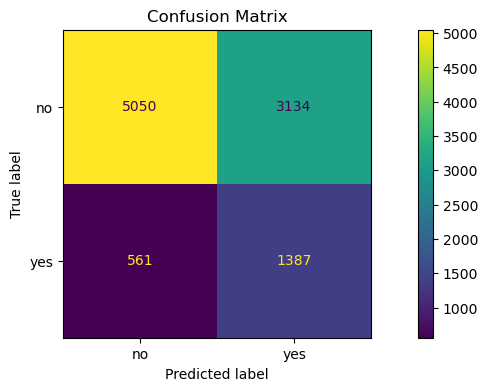

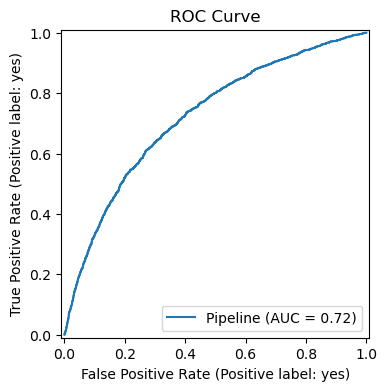

In [9]:
# Show the results
print_search_results(logreg_search, duration)

# Get the Best Model & Calculate Predicted Y and Evaluate
model_logreg = logreg_search.best_estimator_
y_pred = model_logreg.predict(X_test)
classification_metrics(model_logreg, X_test, y_test, y_pred)

## Decision Tree - Random Forest

In [10]:
# Decision Tree

# Establish a pipeline for a grid search & get the best fitted model
randforest_pipeline = make_pipeline(
    RandomForestClassifier(random_state=42)
)
grid_params = {
    # 'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss'],                 # Tree split evaluation function, default is gini
    'randomforestclassifier__n_estimators': [200, 400],            # Number of trees
    'randomforestclassifier__max_depth': [25, 50],
    'randomforestclassifier__max_leaf_nodes': [5, 50],
    'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__class_weight': ['balanced']            # Gives more importance to minority classes ... ?? Improves recall at the expense of precision
}                       

# Run the search
start_time = time.perf_counter()
randforest_search = GridSearchCV(randforest_pipeline, grid_params, cv=5)
# randforest_search = RandomizedSearchCV(randforest_pipeline, grid_params, cv=5)
randforest_search.fit(X_train, y_train)
duration = time.perf_counter() - start_time

------- Search Results --------
Score: 0.7103. Mean: 0.6899 and STD 0.0195
Search Took: 168.74 seconds
Best Parameters: {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 25, 'randomforestclassifier__max_leaf_nodes': 50, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 400}
Top 10 out of 16 combinations:


,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
5,1,0.710349,3.492768,0.116728,{'randomforestclassifier__class_weight': 'bala...
13,1,0.710349,3.453159,0.114768,{'randomforestclassifier__class_weight': 'bala...
7,3,0.710151,3.450294,0.119568,{'randomforestclassifier__class_weight': 'bala...
15,3,0.710151,3.455629,0.115122,{'randomforestclassifier__class_weight': 'bala...
6,5,0.708523,1.744777,0.060957,{'randomforestclassifier__class_weight': 'bala...
14,5,0.708523,1.751419,0.060874,{'randomforestclassifier__class_weight': 'bala...
4,7,0.708350,1.742532,0.060649,{'randomforestclassifier__class_weight': 'bala...
12,7,0.708350,1.746236,0.061076,{'randomforestclassifier__class_weight': 'bala...
1,9,0.671067,1.782121,0.074145,{'randomforestclassifier__class_weight': 'bala...
3,9,0.671067,1.785370,0.074334,{'randomforestclassifier__class_weight': 'bala...


Accuracy: 0.7115
Precision: 0.3594
Recall: 0.6396
F1 Score 0.4602
Specificity: 0.7286
Hamming Loss 0.2885
ROC-AUC Score 0.7459
Gini Index: 0.4918


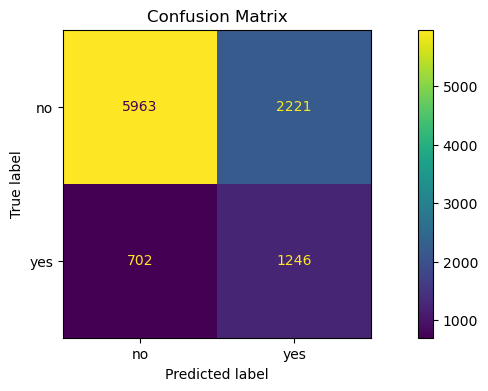

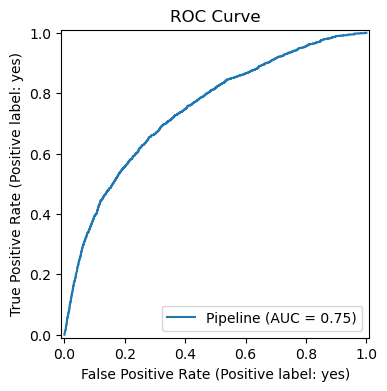

In [11]:
# Show the results
print_search_results(randforest_search, duration)

# Get the Best Model & Calculate Predicted Y and Evaluate
model_randforest = randforest_search.best_estimator_
y_pred = model_randforest.predict(X_test)
classification_metrics(model_randforest, X_test, y_test, y_pred)

## Neural Network - MLPClassifier

In [ ]:
# Neural Network


# param_grid = {
#     'hidden_layer_sizes': [(50,), (30, 15), (100,)],
#     'activation': ['relu', 'tanh'],
#     'solver': ['adam', 'lbfgs'],
#     'alpha': [0.0001, 0.001],
#     'learning_rate_init': [0.001, 0.01]
# }
# https://www.perplexity.ai/search/for-an-mlpclassifier-what-are-nqkwHGTVRRq6kH6L03t6gw
# https://www.perplexity.ai/search/what-are-the-scimitar-default-E_9Y.WQmRqyXuSKdXF.3Ww


# Establish a pipeline for a grid or random search to get the best fitted model
mlpclass_pipeline = make_pipeline(
    MLPClassifier(random_state=42)
)
grid_params = {
    'mlpclassifier__hidden_layer_sizes': [(50,), (25, 10)],         # One layer: 50 Then a two layer
    'mlpclassifier__activation': ['relu', 'tanh'],
    'mlpclassifier__max_iter': [800]                                # At 300 still several not converging
}

# Run the search
start_time = time.perf_counter()
# rand_search = RandomizedSearchCV(logreg_pipeline, grid_params, scoring='accuracy', cv=5)
# mlpclass_search = RandomizedSearchCV(mlpclass_pipeline, grid_params, scoring=custom_f1_score, cv=5)
mlpclass_search = GridSearchCV(mlpclass_pipeline, grid_params, scoring=custom_precision_score, cv=5)


mlpclass_search.fit(X_train, y_train)
duration = time.perf_counter() - start_time


/opt/anaconda3/envs/ml_v4_20250323/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


------- Search Results --------
Score: 0.3204. Mean: 0.3020 and STD 0.0211
Search Took: 223.38 seconds
Best Parameters: {'mlpclassifier__max_iter': 800, 'mlpclassifier__hidden_layer_sizes': (50,), 'mlpclassifier__activation': 'tanh'}
Top 10 out of 4 combinations:


,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
2,1,0.320370,14.283361,0.019105,"{'mlpclassifier__max_iter': 800, 'mlpclassifie..."
3,2,0.319947,13.392251,0.018376,"{'mlpclassifier__max_iter': 800, 'mlpclassifie..."
1,3,0.298870,7.152174,0.017934,"{'mlpclassifier__max_iter': 800, 'mlpclassifie..."
0,4,0.268776,6.871228,0.018081,"{'mlpclassifier__max_iter': 800, 'mlpclassifie..."


Accuracy: 0.8116
Precision: 0.5294
Recall: 0.1802
F1 Score 0.2689
Specificity: 0.9619
Hamming Loss 0.1884
ROC-AUC Score 0.7502
Gini Index: 0.5005


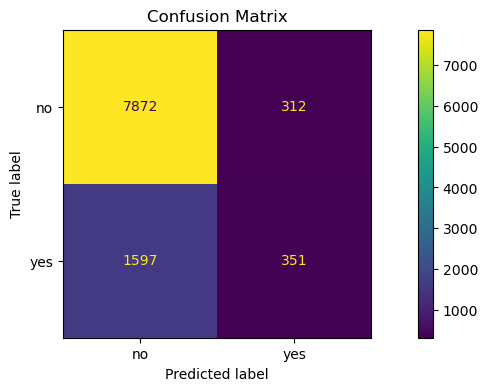

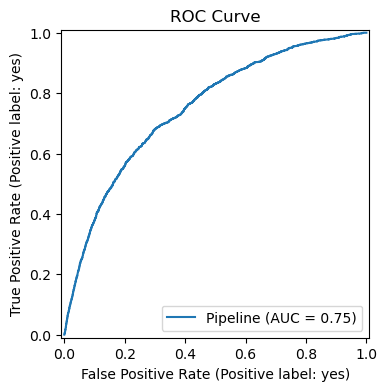

In [15]:
# Show the results
print_search_results(mlpclass_search, duration)

# Get the Best Model & Calculate Predicted Y and Evaluate
model_mlpclass = mlpclass_search.best_estimator_
y_pred = model_mlpclass.predict(X_test)
classification_metrics(model_mlpclass, X_test, y_test, y_pred)

# ?? use
# print("The probabilities across the possible classes for that output are", model.predict_proba(X_test[0:1]))

# from sklearn.model_selection import cross_val_score
# cv_accuracy = np.mean(cross_val_score(model_clf, X_train, y_train, cv=5))
# print(cv_accuracy)